In [1]:
import pandas as pd
import numpy as np
import os
from run_fall_detection_model  import run_fall_detection_model


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

def search_csv_files(directory,activities_of_interest = None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        if activity in file:
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
                    break
    return csv_files



falls_files = search_csv_files(directory='output', activities_of_interest=['Activity13', 'Activity14', 'Activity15'])
adl_files = search_csv_files(directory='output', activities_of_interest=['Activity1', 'Activity2', 'Activity3', 'Activity4', 'Activity5', 'Activity6', 'Activity7', 'Activity8', 'Activity9', 'Activity10', 'Activity11', 'Activity12'])

len(falls_files), len(adl_files)


(198, 678)

In [3]:
def load_and_pad(file, use_gyro=False, max_len=300):
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Define the columns to use
    if use_gyro:
        cols = ['Accelerometer: x-axis (g)', 'Accelerometer: y-axis (g)', 'Accelerometer: z-axis (g)',
                'Gyroscope: x-axis (rad/s)', 'Gyroscope: y-axis (rad/s)', 'Gyroscope: z-axis (rad/s)']
    else:
        cols = ['Accelerometer: x-axis (g)', 'Accelerometer: y-axis (g)', 'Accelerometer: z-axis (g)']
    
    # Clean and convert data for each column
    for col in cols:
        if df[col].dtype == 'object':  # If column has string values
            # Replace incorrect number format (assuming European format with '.' as thousand separator)
            df[col] = df[col].astype(str).str.replace('.', '', n=1)  # Remove first period (thousand separator)
            df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='coerce')  # Replace comma with period for decimal

    # Extract features and convert to numpy array
    features = df[cols].to_numpy().astype('float32')
    
    # Pad or truncate as needed
    if features.shape[0] > max_len:
        features = features[:max_len, :]
    elif features.shape[0] < max_len:
        pad = np.zeros((max_len - features.shape[0], features.shape[1]), dtype='float32')
        features = np.vstack((features, pad))
    
    return features




def build_dataset(falls_files, adl_files, max_len=300):
    X_acc, X_all, y = [], [], []

    for file in falls_files:
        X_acc.append(load_and_pad(file, use_gyro=False, max_len=max_len))
        X_all.append(load_and_pad(file, use_gyro=True, max_len=max_len))
        y.append(1)

    for file in adl_files:
        X_acc.append(load_and_pad(file, use_gyro=False, max_len=max_len))
        X_all.append(load_and_pad(file, use_gyro=True, max_len=max_len))
        y.append(0)

    return np.array(X_acc), np.array(X_all), np.array(y)



In [4]:
X_acc, X_all, y = build_dataset(falls_files, adl_files)


print("Accelerometer only:", X_acc.shape)
print("Accelerometer + Gyroscope:", X_all.shape)
print("Labels:", y.shape)

Accelerometer only: (876, 300, 3)
Accelerometer + Gyroscope: (876, 300, 6)
Labels: (876,)


In [5]:
from imblearn.over_sampling import SMOTE

USE_GYRO = False

X = X_all if USE_GYRO else X_acc
X_2d = X.reshape((X.shape[0], -1))

# Remove samples with NaNs
mask = ~np.isnan(X_2d).any(axis=1)
X_clean = X_2d[mask]
y_clean = y[mask]

print(f"Removed {len(y) - len(y_clean)} samples due to NaNs.")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_clean, y_clean)

# Reshape back to 3D for CNN
X_resampled = X_resampled.reshape((-1, 300, X.shape[2]))

print("✅ SMOTE done:")
print("X shape:", X_resampled.shape)
print("Label counts:", np.bincount(y_resampled))

Removed 19 samples due to NaNs.
✅ SMOTE done:
X shape: (1318, 300, 3)
Label counts: [659 659]


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Removed 19 samples due to NaNs.
✅ SMOTE applied
X shape: (1318, 300, 3)
Label counts: [659 659]
Epoch 1/20


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6263 - loss: 0.6072 - val_accuracy: 0.7867 - val_loss: 0.5282
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8317 - loss: 0.4341 - val_accuracy: 0.7962 - val_loss: 0.4597
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8383 - loss: 0.3959 - val_accuracy: 0.7962 - val_loss: 0.4648
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8332 - loss: 0.4011 - val_accuracy: 0.8009 - val_loss: 0.4647
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8649 - loss: 0.3514 - val_accuracy: 0.7962 - val_loss: 0.4621
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8315 - loss: 0.3820 - val_accuracy: 0.8009 - val_loss: 0.4605
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8365 - loss: 0.3767 - val_accuracy: 0.7915 - val_loss: 0.4826
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8486 - loss: 0.3447 - val_accuracy: 0.7773 - val_loss: 0.4763
Epo

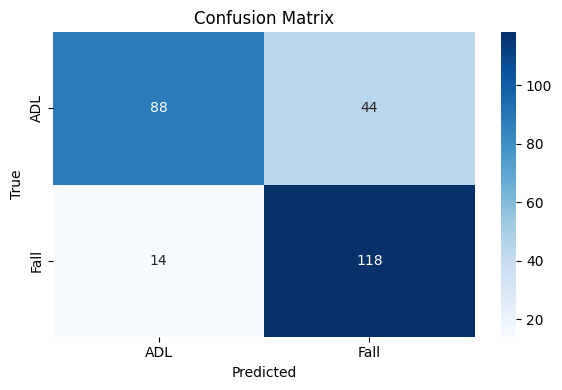


✅ Test Accuracy: 0.78

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       132
           1       0.73      0.89      0.80       132

    accuracy                           0.78       264
   macro avg       0.80      0.78      0.78       264
weighted avg       0.80      0.78      0.78       264



In [6]:
model, history = run_fall_detection_model(X_acc, X_all, y)


Removed 19 samples due to NaNs.
✅ SMOTE applied
X shape: (1318, 300, 6)
Label counts: [659 659]
Epoch 1/20


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6628 - loss: 0.6255 - val_accuracy: 0.8009 - val_loss: 0.4628
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8292 - loss: 0.4306 - val_accuracy: 0.8104 - val_loss: 0.4558
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8714 - loss: 0.3562 - val_accuracy: 0.7962 - val_loss: 0.4377
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8540 - loss: 0.3623 - val_accuracy: 0.8057 - val_loss: 0.4826
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8521 - loss: 0.3424 - val_accuracy: 0.7915 - val_loss: 0.4820
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - loss: 0.3303 - val_accuracy: 0.7915 - val_loss: 0.4865
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8616 - loss: 0.3320 - val_accuracy: 0.7915 - val_loss: 0.5888
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3185 - val_accuracy: 0.7962 - val_loss: 0.5625
Epo

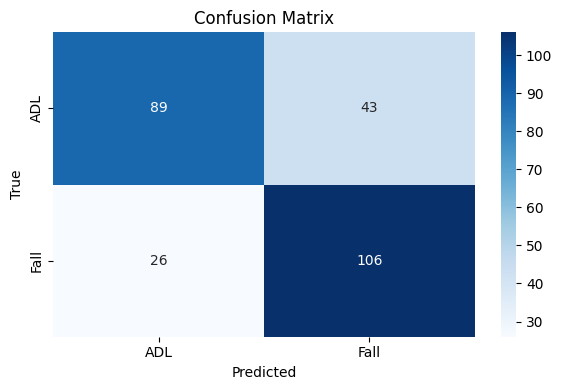


✅ Test Accuracy: 0.74

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       132
           1       0.71      0.80      0.75       132

    accuracy                           0.74       264
   macro avg       0.74      0.74      0.74       264
weighted avg       0.74      0.74      0.74       264



In [7]:
model, history = run_fall_detection_model(X_acc, X_all, y, use_gyro=True)

Removed 19 samples due to NaNs.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6994 - loss: 0.5719 - val_accuracy: 0.7518 - val_loss: 0.4448
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7600 - loss: 0.4172 - val_accuracy: 0.7810 - val_loss: 0.3922
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7727 - loss: 0.3762 - val_accuracy: 0.7445 - val_loss: 0.3897
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7664 - loss: 0.3536 - val_accuracy: 0.7372 - val_loss: 0.4096
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8032 - loss: 0.3442 - val_accuracy: 0.7445 - val_loss: 0.3912
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8090 - loss: 0.3405 - val_accuracy: 0.7080 - val_loss: 0.3911
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7798 - loss: 0.3746 - val_accuracy: 0.7153 - val_loss: 0.4080
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7981 - loss: 0.3489 - 

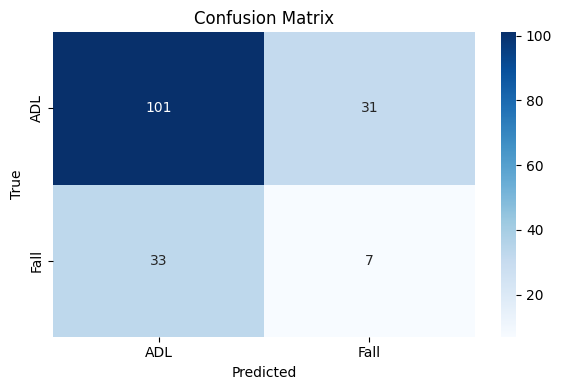


✅ Test Accuracy: 0.63

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       132
           1       0.18      0.17      0.18        40

    accuracy                           0.63       172
   macro avg       0.47      0.47      0.47       172
weighted avg       0.62      0.63      0.62       172



In [8]:
# Without SMOTE

model, history = run_fall_detection_model(X_acc, X_all, y, apply_smote=False)